### hetGPy `Expected Improvement` example 

This notebook showcases one of the sequential design criteria. Given a trained model (like those we have observed in previous notebooks), we often are interested in identifying suitable input locations for our next acquisition from the data-generating process.

If our goal is to globally minimize some expensive function $f$, one of the most popular acquisition functions is _Expected Improvement_ [Garnett 2023 Ch. 7.3](https://bayesoptbook.com/book/bayesoptbook.pdf) [Gramacy (2020) Ch. 7.2](https://bookdown.org/rbg/surrogates/chap7.html#chap7ei)


Using the notation from [Gramacy (2020) Ch. 7.2](https://bookdown.org/rbg/surrogates/chap7.html#chap7ei), assume that we have a current observed minimum (noisy) realization from our data-generating process $f$ that we write as $f_{\min}^n$. We also assume that we have a predictive mean $\mu_n(x)$ and predictive standard deviation $\sigma_n(x)$ (from a GP).

We can evaluate the Expected Improvement for some potential input $x \in X$ as:
\begin{align*}
\mathrm{EI}(x) = (f^n_{\min} - \mu_n(x))\,\Phi\!\left(
\frac{f^n_{\min} - \mu_n(x)}{\sigma_n(x)}\right)
+ \sigma_n(x)\, \phi\!\left(
\frac{f^n_{\min} - \mu_n(x)}{\sigma_n(x)}\right)
\end{align*}

Where $\Phi$ and $\phi$ are the Gaussian CDF and PDF, respectively. Notice how Expected Improvement is essentially a tradeoff between "exploitation" (capitalizing on the observed minimum) "exploration" (steering towards locations with large predictive uncertainty).  

This example is from `help(crit_EI)` in the `hetGP` R package documentation.

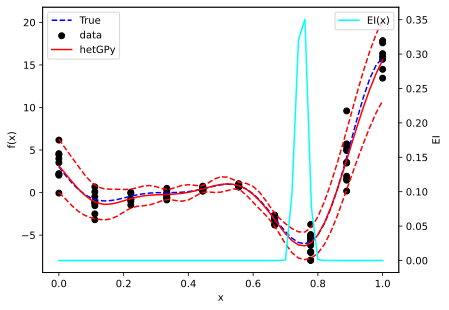

In [5]:
from hetgpy import hetGP
from hetgpy.test_functions import f1d
from hetgpy.optim import crit_EI
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np


# plotting
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

rand = np.random.default_rng(42)

## nonstationary noise field
def noiseFun(x,coef=1.1, scale = 1):
    return (scale * (coef + np.cos(x*2*np.pi))).squeeze()

## noisy output function
def ftest(x):
    return f1d(x) + rand.normal(size = x.shape[0], loc = 0, scale = noiseFun(x))


## Training
n_init = 10 # number of unique designs
N_init = 100 # total number of points
X = np.linspace(0, 1,n_init).reshape(-1,1)
X = X[rand.choice(n_init, size = N_init, replace = True),:]
Z = ftest(X)
## Predictive grid
ngrid = 51
xgrid = np.linspace(0,1, ngrid)
Xgrid = xgrid.reshape(-1,1)

    

f1d_xgrid = f1d(xgrid)
model = hetGP() 
model.mle(X = X, Z = Z, lower = np.array([0.001]), upper = np.array([1.0]), 
               known = {}, init = {},maxit=5e3,settings={'factr':10},covtype = "Matern5_2")

EIgrid = crit_EI(Xgrid, model)
preds = model.predict(x = Xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()

f, ax = plt.subplots(nrows = 1, ncols = 1)

ax.plot(xgrid,f1d_xgrid,color='blue',linestyle='dashed',label='True')
ax.scatter(X.squeeze(),Z,color='black',label = 'data')                    

ax.plot(xgrid,preds['mean'],color='red',label='hetGPy')
ax.plot(xgrid,preds['lower'],color='red',linestyle='dashed') 
ax.plot(xgrid,preds['upper'],color='red',linestyle='dashed') 
ax.set_ylabel('f(x)')
ax.set_xlabel('x')

ax2 = ax.twinx()
ax2.plot(xgrid,EIgrid,color='cyan',label='EI(x)')
ax2.set_ylabel('EI')
# Legends
ax.legend()
ax2.legend();

In this case, the Expected Improvement is maximized near the observed minimum, indicating that our next function acquisition should be near that point.